# Reconocimiento de Autores Canciones de Queen 

## Librerías

In [1]:
import os
import glob
import librosa, librosa.display
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import pandas as pd
import plotly.graph_objects as go
import skimage.io
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, InputLayer, Flatten, LSTM, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from keras import backend as K
from sklearn.metrics import classification_report
K.clear_session()
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('Hola')

## Data

In [2]:
# white noise
#bg, sr = librosa.load('./Audio/WhiteNoise/whiteNoise.WAV', sr=None)

## Funciones

In [3]:
## Mueve el tiempo de incio y fin de una cación, este agrega un ruido casi nulo a la canción
def time_shift(wav, inf_limit = -990000, sup_limit = 990000):
    """time_shift(wav, inf_limit = -990000, sup_limit = 990000)-> np.array
    La función regresa un array de la canción pero con un desplazamiento al inicio o final
    """
    ## time shiftting
    ## random start
    start_ = int(np.random.uniform(inf_limit,sup_limit))
    ## si es mayor igual a 0 se agrega un ruido muy bajo al final
    if start_ >= 0:
        wav_time_shift = np.r_[wav[start_:], np.random.uniform(-0.001,-0.001, start_)]
    ## en otro caso se agrega ruido al principio
    else:
        wav_time_shift = np.r_[np.random.uniform(-0.0001,0.0001, -start_), wav[:start_]]
    
    return wav_time_shift

In [4]:
def speed_tune(wav):
    """speed_tune(wav)-> np.array
    La función regresa un array con la canción reducida o alargada, esto para modificar el tiempo de duración
    y la velocidad de la canción.
    """
    ## speed tuning
    ## valor aleatorio para acortar o alargar canción 
    speed_rate = np.random.uniform(0.95,1.05)
    ## resize de la canción
    wav_speed_tune = cv2.resize(wav, (1, int(len(wav) * speed_rate))).squeeze()
    
    return wav_speed_tune

In [5]:
def white_noise(wav):
    """white_noise(wav)-> np.array
    A toda la canción le agrega un ruido blanco de fondo
    """
    ## white noise background
    start_ = np.random.randint(bg.shape[0]-len(wav))
    bg_slice = bg[start_ : start_+len(wav)]
    wav_with_bg = wav * np.random.uniform(0.8, 1.2) + bg_slice * np.random.uniform(0, 0.1)
    
    return wav_with_bg

In [6]:
def DataAugmentation(wav_file):
    """DataAugmentation(wav_file)->np.array
    La funcíon aplica los distinto de Data Augmentation como time shiftting, speed tune y white noise.
    Se aplican 15 filtros de time shiftting y a estos 10 se le aplica speed tune y white noise regresando
    64 registros.
    """
    ## wav file array and sample rate CD
    wav, sr = librosa.load(wav_file, sr=44100)
    
    ## time shift
    wav_time_shift = [time_shift(wav) for i in range(0, 15)]
    wav_time_shift.append(wav)
    
    ## speed tune
    wav_speed = [speed_tune(wav_i) for wav_i in wav_time_shift] + wav_time_shift
    del wav_time_shift

    ## white noise
    wav_white_noise = [white_noise(wav_i) for wav_i in wav_speed] + wav_speed
    del wav_speed

    return wav_white_noise

In [7]:
def mel_spectrogram_image(signal, output_file):
    """mel_spectrogram_image(signal, output_file)->.png
    La función recibe la señal de una canción y guarda en la carpeta de salida 
    el mel espectrograma de dicha cancion. 
    """
    # mel espectrograma
    S = librosa.feature.melspectrogram(signal, sr=44100, n_fft=2048, hop_length=512)

    # escalamiento de los valores
    log_S = librosa.amplitude_to_db(S, ref=np.max)
    
    ## salvando espectrograma
    skimage.io.imsave(output_file, log_S)

## Preprocesamiento

### Data Augmentation and MEL Spectrogram

In [8]:
### generating and saving spectrograms train
#directory = "./Audio/"
## integrantes
#for artist in ['Brian', 'Freddie', 'John', 'Roger']:
#    ## directorio de canciones
#    filenames = os.listdir(os.path.join(directory,f"{artist}"))
#    counter = 0
#    ## canciones
#    for f in tqdm(filenames):
#        file_name = directory + artist + '/' + f
#        ## aplicación de data augmentation
#        wav_sig = DataAugmentation(file_name)
#        counter_2 = 0
#        for sig in wav_sig:
#            output_filename = "./Spectrograms/" + artist + '/' + artist + str(counter)+ str(counter_2) + '.png'
#            ## guardado de mel spectrogram
#            mel_spectrogram_image(sig, output_filename)
#            counter_2 += 1
#        counter += 1"""

In [9]:
## Mel Spectrogram Test
#directory = "./Audio/"
## artistas
#for artist in ['Brian_Test', 'Freddie_Test', 'John_Test', 'Roger_Test']:
#    filenames = os.listdir(os.path.join(directory,f"{artist}"))
#    counter = 0
#    # canciones
#    for f in tqdm(filenames):
#        file_name = directory + artist + '/' + f
#        ## señal de canción
#        wav, sr = librosa.load(file_name, sr=44100)
#        ## conteo de canción
#        output_filename = "./Spectrograms/" + artist + '/' + artist+ str(counter) + '.png'
#        ## creación de mel spectrogram
#        mel_spectrogram_image(wav, output_filename)
#        counter+=1

### Importar Imagenes

In [10]:
## size images
size = 230
# creating complete array of spectrograms
spectrograms_train = []
artists_train = []
for artist in ['Brian', 'Freddie', 'John', 'Roger']:
    counter = 0
    for spectro in tqdm(os.listdir(f"./Spectrograms/{artist}")):
        ## resize de imagen
        spectrograms_train.append(np.array(cv2.resize(cv2.imread(f"./Spectrograms/{artist}/" + spectro),
                                                dsize=(size,size)))/255)
        ## labels
        artists_train.append(artist)
        counter+=1
        
spectrograms_train = np.array(spectrograms_train)

100%|██████████| 1226/1226 [00:38<00:00, 31.70it/s]


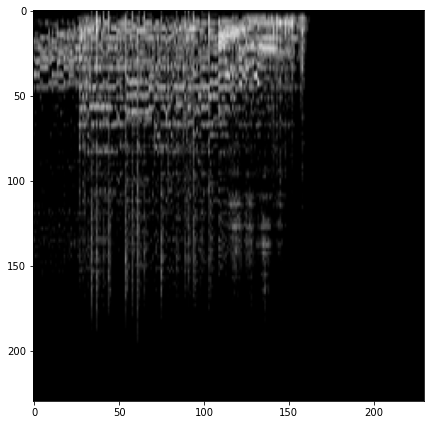

In [11]:
plt.figure(figsize=(7,12))
#plt.imshow(spectrograms_train[15])
#plt.imshow(spectrograms_train[5236])
#plt.imshow(spectrograms_train[3236])
plt.imshow(spectrograms_train[1236])
plt.show()

In [12]:
## creating complete array of spectrograms
spectrograms_test = []
artists_test = []
for artist in ['Brian_Test', 'Freddie_Test', 'John_Test', 'Roger_Test']:
    for spectro in tqdm(os.listdir(f"./Spectrograms/{artist}")):
        ## resize de imagen
        spectrograms_test.append(np.array(cv2.resize(cv2.imread(f"./Spectrograms/{artist}/" + spectro),
                                                dsize=(size,size)))/255)
        ## labels
        artists_test.append(artist[:-5])
        
spectrograms_test = np.array(spectrograms_test)

100%|██████████| 5/5 [00:00<00:00, 36.97it/s]


Mel Spectrogram


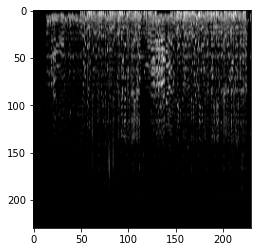

In [13]:
print('Mel Spectrogram')
plt.imshow(spectrograms_train[0])
plt.show()

In [14]:
##
pd.Series(artists_train).value_counts()

Freddie    2732
Brian      2398
Roger      1226
John       1162
dtype: int64

### One hot encoding

In [15]:
## mapping
artist_map = {'Brian':0, 'Freddie':1, 'John':2, 'Roger':3}
## TRAIN
artist_categorical_train = to_categorical(pd.Series(artists_train).map(artist_map))
del artists_train
## Test
artist_categorical_test = to_categorical(pd.Series(artists_test).map(artist_map))
del artists_test

## Modelo Convolucional

In [16]:
## architecture
model = Sequential()
model.add(InputLayer(input_shape=(size,size,3)))
model.add(Conv2D(filters = 12, kernel_size = (2,2),
                                 padding = 'valid', strides = 1, activation = 'relu'))
model.add(MaxPool2D(pool_size = (3,3), strides=(2,2)))
model.add(Conv2D(filters = 5, kernel_size = (2,2), padding = 'valid', strides = 1, activation = 'relu'))
model.add(MaxPool2D(pool_size = (3,3), strides=(2,2), padding="same"))
model.add(Flatten())
model.add(Dense(256, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2()))
model.add(Dropout(.5))
model.add(Dense(64, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2()))
model.add(Dropout(.3))
model.add(Dense(4, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 229, 229, 12)      156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 114, 114, 12)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 113, 113, 5)       245       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 57, 57, 5)         0         
_________________________________________________________________
flatten (Flatten)            (None, 16245)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               4158976   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

In [17]:
## early stopping y checkpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

early = EarlyStopping(monitor = 'val_accuracy', min_delta = 3e-2, patience = 15)
check_path = "modelCNN.hdf5"
checkpoint = ModelCheckpoint(filepath=check_path, monitor = 'val_accuracy', save_best_only = True,
                             save_weights_only = False, mode = 'max', save_freq = "epoch")

## compiling
model.compile(optimizer=Adam(0.00001), loss=CategoricalCrossentropy(), metrics=['accuracy'])
history = model.fit(spectrograms_train.reshape(-1,size,size,3), artist_categorical_train, epochs = 140, batch_size = 64,
                    validation_data = (spectrograms_test.reshape(-1,size,size,3), artist_categorical_test), callbacks=[early, checkpoint])

model.load_weights(check_path)

Epoch 1/140
118/118 [==============================] - 3s 30ms/step - loss: 7.0631 - accuracy: 0.3545 - val_loss: 6.7211 - val_accuracy: 0.5000
Epoch 2/140
118/118 [==============================] - 3s 26ms/step - loss: 6.4642 - accuracy: 0.3831 - val_loss: 6.1830 - val_accuracy: 0.5333
Epoch 3/140
118/118 [==============================] - 3s 24ms/step - loss: 5.9533 - accuracy: 0.4004 - val_loss: 5.7242 - val_accuracy: 0.4333
Epoch 4/140
118/118 [==============================] - 3s 24ms/step - loss: 5.5039 - accuracy: 0.4227 - val_loss: 5.3102 - val_accuracy: 0.4667
Epoch 5/140
118/118 [==============================] - 3s 24ms/step - loss: 5.1197 - accuracy: 0.4331 - val_loss: 4.9696 - val_accuracy: 0.5333
Epoch 6/140
118/118 [==============================] - 3s 24ms/step - loss: 4.7865 - accuracy: 0.4528 - val_loss: 4.6652 - val_accuracy: 0.5000
Epoch 7/140
118/118 [==============================] - 3s 24ms/step - loss: 4.4905 - accuracy: 0.4649 - val_loss: 4.3960 - val_accuracy:

In [21]:
## Loss function
trace = go.Scatter(x = np.arange(len(history.history["loss"])), y= history.history["loss"], mode="lines", name="train_loss")
trace2 = go.Scatter(x = np.arange(len(history.history["val_loss"])), y= history.history["val_loss"], mode="lines", name="val_loss")
fig = go.Figure()
fig.add_traces([trace, trace2])
fig.add_vline(x=16, line_width=3, line_dash="dash", line_color="green")
fig.update_layout(dict(title= "Loss"))
fig.show()

In [19]:
## Train Accuracy
print('Train Metrics')
## best model 
model.load_weights(check_path)

## model accuracy
print(classification_report(artist_categorical_train.argmax(axis=1), model.predict_classes(spectrograms_train.reshape(-1,size,size,3))))

Train Metrics
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.64      0.85      0.73      2398
           1       0.63      0.86      0.73      2732
           2       0.93      0.18      0.30      1162
           3       0.95      0.29      0.44      1226

    accuracy                           0.66      7518
   macro avg       0.79      0.54      0.55      7518
weighted avg       0.73      0.66      0.62      7518



In [20]:
## Train Accuracy
print('Test Metrics')
## model accuracy
print(classification_report(artist_categorical_test.argmax(axis=1), model.predict_classes(spectrograms_test.reshape(-1,size,size,3))))

Test Metrics
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.52      1.00      0.69        11
           2       1.00      0.25      0.40         4
           3       0.00      0.00      0.00         5

    accuracy                           0.67        30
   macro avg       0.63      0.51      0.49        30
weighted avg       0.66      0.67      0.60        30

